In [1]:
# !pip install prettytable

Please install flaml, lightgbm, xgboost, econml

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from flaml import AutoML
# from sklearn.ensemble import HistGradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet
# from sklearn.tree import DecisionTreeRegressor

from lightgbm import LGBMRegressor
from prettytable import PrettyTable
import sys  
import os
root_path = os.path.realpath('/..')
sys.path.insert(0, root_path)
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

from tw_experimentation.variance_reduction.diff_in_means import DifferenceInMeans
from tw_experimentation.variance_reduction.cuped import CUPED, multiple_CUPEDs, MultivariateCUPED
from tw_experimentation.variance_reduction.utils import create_pretty_table, query_snowflake, bootstrap_generator, subsample_generator, bootstrap_data, subsample_data, aaify, add_synthetic_effect, diff_in_means
from tw_experimentation.variance_reduction.mlrate import MLRATE, AltMLRATE
from tw_experimentation.variance_reduction.cupac import CUPAC
from tw_experimentation.variance_reduction.doubly_robust import DoublyRobustEstimator
from tw_experimentation.variance_reduction.evaluation_pipeline import VREvaluation, VREvaluationAll, VREvaluationGrid
from tw_experimentation.variance_reduction.multivariate_regression import MultivariateRegression, MultivariateRegressionAdjusted


# Simple synthetic data

In [3]:
def generate_synthetic_data(n):

    # pre experiment metric
    group_0 = np.random.exponential(10, n//2)
    group_1 = np.random.exponential(10, n//2)

    pre_metric = np.concatenate([group_0, group_1])

    # experiment metric
    ctrl_group_0 = group_0 + np.random.normal(0,1, n//2)
    treatment_group_1 = group_1 + np.random.normal(5,1, n//2) + np.random.normal(0,1, n//2)

    exp_metric = np.concatenate([ctrl_group_0, treatment_group_1])

    # treatment
    treatment = np.concatenate([np.zeros(n//2), np.ones(n//2)])

    # assemble dataframe
    df = pd.DataFrame({
        'Y': exp_metric,
        'T': treatment,
        'X': pre_metric
    })

    # shuffle
    df = df.sample(frac=1).reset_index(drop=True)

    return df


In [4]:
simple_synthetic_df = generate_synthetic_data(10000)

# More complicated synthetic data


In [5]:
def dgp(n=2000, p=10, linear=True, constant=True):
    """DGP from https://github.com/muratunalphd/Blog-Posts/blob/main/variance-reduction-methods/MLRATE.ipynb"""
        
    Xmat = np.random.multivariate_normal(np.zeros(p), np.eye(p), size=n).astype('float32')

    T = np.random.binomial(1, 0.5, n).astype('int8')

    col_list = ['X' + str(x) for x in range(1,(p+1))]

    df = pd.DataFrame(Xmat, columns = col_list)
    
    # functional form of the covariates
    if linear:
        B = 225 + 50*df['X1'] + 5*df['X2'] + 20*(df['X3']-0.5) + 10*df['X4'] + 5*df['X5']
    else:
        B = 225 + 50*df['X1'] + 5*np.sin(np.pi*df['X1']*df['X2'] ) + 10*(df['X3']-0.5)**2 + 10*df['X4']**2 + 5*df['X5']**3
    
    # constant ate or non-constant
    tau = 1.8 if constant else 5*df['X1'] + 5*np.log(1 + np.exp(df['X2']))
    
    # Y = (B + tau*T + np.random.normal(0,25,n)).astype('float32')
    Y = (B + tau*T + np.random.normal(0,25,n)).astype('float32')
        
    df['T'] = T
    df['Y'] = Y    
    return df

In [6]:

nonlinear_synthetic_df = dgp(n=10000, p=20, linear=False, constant=True)
linear_synthetic_df = dgp(n=10000, p=20, linear=True, constant=True)

# Big evaluation of nonlinear synthetic data

In [7]:
base_params_map= {

    'DifferenceInMeans': {
    },
    
    'CUPED': {
        'covariate_column': 'X1'
    },

    'MultivariateCUPED': {
        'covariate_columns': None
    },

    'MultivariateRegression': {
        'covariate_columns': None
    },

    'MultivariateRegressionAdjusted': {
        'covariate_columns': None
    },


    # 'CUPAC': {
    #     'pre_experiment_data': 'ml_synthetic_df',
    #     'covariate_columns': list(ml_synthetic_df.columns[2:10]),
    #     'model': HistGradientBoostingRegressor,
    #     'model_init_config': {},
    #     'model_fit_config': {}
    # },

    'MLRATE': {
        'K_splits': 2,
        'covariate_columns': None,
        'model': None,
        'model_init_config': {},
        'model_fit_config': {}
    },

    'DoublyRobustEstimator': {
        'covariate_columns': None,
        'model_regression': None,
        'model_propensity': 'auto',
        'mc_iters':5
    }

}

In [8]:
parameter_grid = VREvaluationGrid.generate_parameters_grid(base_methods_params_map=base_params_map,
                         covariate_columns_list = [nonlinear_synthetic_df.columns.to_list()[0:4*i] for i in range(1,6)],
                         models = [ElasticNet, LGBMRegressor],
                         model_init_configs = [{}, {}],
                         model_fit_configs = [{}, {}])

In [9]:
evaluation_grid = VREvaluationGrid([DifferenceInMeans, CUPED, MultivariateRegression, MultivariateRegressionAdjusted, MultivariateCUPED, MLRATE])
evaluation_grid = evaluation_grid.run(data=nonlinear_synthetic_df, 
                                      treatment_column='T',
                                      target_column='Y',
                                      method_params_grid=parameter_grid)

----- Running evaluation for parameter grid index (0, 0)... -----
Running DifferenceInMeans...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 376.91it/s]


Running CUPED...


 10%|████▏                                     | 10/100 [00:00<00:00, 93.89it/s]

[248.97738869  50.14779647]
[248.81423665  50.71307674]
[249.24513403  50.48689802]
[249.35896416  50.5288899 ]
[248.95375506  50.08286498]
[247.87879892  49.39886004]
[248.46776445  49.78703948]
[247.82121017  50.63007353]
[248.221359    50.00309946]
[248.93570147  50.83490177]
[249.16762343  50.57753206]
[248.68039265  50.97343399]
[248.35153007  50.73206207]
[248.54226009  51.46788038]
[248.134276    50.02999516]
[248.80620611  49.52521416]
[249.11626981  50.96691076]
[248.1946633  49.7097643]
[248.44491855  50.69500718]
[248.2582928  50.399324 ]


 30%|████████████▌                             | 30/100 [00:00<00:00, 95.46it/s]

[249.21537017  50.30157114]
[248.7583243   49.97929146]
[248.37168412  50.18303029]
[248.00587873  50.22484534]
[248.91903749  50.03091383]
[248.82634948  49.77328662]
[247.58141016  50.19194133]
[248.04963373  50.09515899]
[249.31770756  49.23228794]
[248.86479408  50.20669743]
[248.8523713   50.52236133]
[248.42124312  50.36951551]
[248.14881503  49.7703175 ]
[248.68324782  50.23347673]
[248.61162526  49.90934829]
[248.90367579  50.26609236]
[248.27301605  50.02490778]
[248.89399755  50.03525633]
[248.55590234  50.09332332]
[248.50237659  50.27200182]


 50%|█████████████████████                     | 50/100 [00:00<00:00, 95.63it/s]

[248.38783309  50.89667941]
[248.7134886   50.14667566]
[248.53152643  50.08876771]
[249.17897242  50.13159302]
[249.2488348   51.05831737]
[248.53640982  50.26612035]
[248.50819581  50.03977166]
[248.77461665  50.05385707]
[248.53895955  49.67069108]
[248.34881921  50.58006143]
[248.68739099  50.84222193]
[249.05443812  50.26077784]
[249.33301613  50.67476603]
[248.3761379   50.93670234]
[248.77258459  49.53767174]
[248.16993889  49.98830934]
[248.22477845  50.85319555]
[248.81897915  50.255267  ]
[249.20710223  50.14255441]
[249.08049574  50.13490177]


 70%|█████████████████████████████▍            | 70/100 [00:00<00:00, 96.54it/s]

[248.59724539  50.08859281]
[248.93357948  49.89836061]
[249.25994293  50.45944504]
[248.6861694   50.76663398]
[248.90606462  50.43017535]
[248.1889801   50.25230334]
[248.1891495   49.88745391]
[248.67066872  50.13352432]
[248.99478864  49.52539043]
[248.40595547  50.81329275]
[249.37524434  50.1315859 ]
[248.88717967  50.39219932]
[248.76425932  50.26012606]
[249.20776455  49.87296891]
[248.84828006  50.62225764]
[249.28585848  50.30322828]
[248.55225453  50.10847878]
[248.88873344  50.14366372]
[247.85607276  49.35053194]
[248.55148534  50.36505449]


 90%|█████████████████████████████████████▊    | 90/100 [00:00<00:00, 97.10it/s]

[248.44083203  50.64899789]
[249.17942736  50.52270403]
[249.01645483  49.98462578]
[248.23299234  50.3607232 ]
[248.46664458  50.08752925]
[248.99478212  50.58386173]
[248.6249309   50.40403131]
[248.84138302  49.62334812]
[248.78509909  50.21066503]
[248.90335736  50.1735144 ]
[249.10895724  50.16100534]
[248.92270195  50.18490831]
[248.3033093  50.3787387]
[249.10861836  50.23222448]
[248.61340095  49.7720086 ]
[248.89121319  50.25224595]
[248.7254486   49.83484862]
[249.18151418  50.42853022]
[248.48472863  49.67190682]
[248.37471597  50.68863945]


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 96.29it/s]


Running MultivariateRegression...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 97.93it/s]


Running MultivariateRegressionAdjusted...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 63.27it/s]


Running MultivariateCUPED...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 119.88it/s]


Running MLRATE...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 57.73it/s]


Done!
----- Running evaluation for parameter grid index (0, 1)... -----
Running DifferenceInMeans...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 388.34it/s]


Running CUPED...


 10%|████▏                                     | 10/100 [00:00<00:00, 92.27it/s]

[248.97738869  50.14779647]
[248.81423665  50.71307674]
[249.24513403  50.48689802]
[249.35896416  50.5288899 ]
[248.95375506  50.08286498]
[247.87879892  49.39886004]
[248.46776445  49.78703948]
[247.82121017  50.63007353]
[248.221359    50.00309946]
[248.93570147  50.83490177]
[249.16762343  50.57753206]
[248.68039265  50.97343399]
[248.35153007  50.73206207]
[248.54226009  51.46788038]
[248.134276    50.02999516]
[248.80620611  49.52521416]
[249.11626981  50.96691076]
[248.1946633  49.7097643]
[248.44491855  50.69500718]


 30%|████████████▌                             | 30/100 [00:00<00:00, 84.08it/s]

[248.2582928  50.399324 ]
[249.21537017  50.30157114]
[248.7583243   49.97929146]
[248.37168412  50.18303029]
[248.00587873  50.22484534]
[248.91903749  50.03091383]
[248.82634948  49.77328662]
[247.58141016  50.19194133]
[248.04963373  50.09515899]
[249.31770756  49.23228794]
[248.86479408  50.20669743]
[248.8523713   50.52236133]
[248.42124312  50.36951551]
[248.14881503  49.7703175 ]
[248.68324782  50.23347673]
[248.61162526  49.90934829]
[248.90367579  50.26609236]


 48%|████████████████████▏                     | 48/100 [00:00<00:00, 86.64it/s]

[248.27301605  50.02490778]
[248.89399755  50.03525633]
[248.55590234  50.09332332]
[248.50237659  50.27200182]
[248.38783309  50.89667941]
[248.7134886   50.14667566]
[248.53152643  50.08876771]
[249.17897242  50.13159302]
[249.2488348   51.05831737]
[248.53640982  50.26612035]
[248.50819581  50.03977166]
[248.77461665  50.05385707]
[248.53895955  49.67069108]
[248.34881921  50.58006143]
[248.68739099  50.84222193]
[249.05443812  50.26077784]
[249.33301613  50.67476603]
[248.3761379   50.93670234]
[248.77258459  49.53767174]


 68%|████████████████████████████▌             | 68/100 [00:00<00:00, 91.92it/s]

[248.16993889  49.98830934]
[248.22477845  50.85319555]
[248.81897915  50.255267  ]
[249.20710223  50.14255441]
[249.08049574  50.13490177]
[248.59724539  50.08859281]
[248.93357948  49.89836061]
[249.25994293  50.45944504]
[248.6861694   50.76663398]
[248.90606462  50.43017535]
[248.1889801   50.25230334]
[248.1891495   49.88745391]
[248.67066872  50.13352432]
[248.99478864  49.52539043]
[248.40595547  50.81329275]
[249.37524434  50.1315859 ]
[248.88717967  50.39219932]
[248.76425932  50.26012606]
[249.20776455  49.87296891]
[248.84828006  50.62225764]


 88%|████████████████████████████████████▉     | 88/100 [00:00<00:00, 95.09it/s]

[249.28585848  50.30322828]
[248.55225453  50.10847878]
[248.88873344  50.14366372]
[247.85607276  49.35053194]
[248.55148534  50.36505449]
[248.44083203  50.64899789]
[249.17942736  50.52270403]
[249.01645483  49.98462578]
[248.23299234  50.3607232 ]
[248.46664458  50.08752925]
[248.99478212  50.58386173]
[248.6249309   50.40403131]
[248.84138302  49.62334812]
[248.78509909  50.21066503]
[248.90335736  50.1735144 ]
[249.10895724  50.16100534]
[248.92270195  50.18490831]
[248.3033093  50.3787387]
[249.10861836  50.23222448]
[248.61340095  49.7720086 ]


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.63it/s]


[248.89121319  50.25224595]
[248.7254486   49.83484862]
[249.18151418  50.42853022]
[248.48472863  49.67190682]
[248.37471597  50.68863945]
Running MultivariateRegression...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 68.32it/s]


Running MultivariateRegressionAdjusted...


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 40.11it/s]


Running MultivariateCUPED...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 126.85it/s]


Running MLRATE...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 59.13it/s]


Done!
----- Running evaluation for parameter grid index (0, 2)... -----
Running DifferenceInMeans...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 396.20it/s]


Running CUPED...


 10%|████▏                                     | 10/100 [00:00<00:00, 98.89it/s]

[248.97738869  50.14779647]
[248.81423665  50.71307674]
[249.24513403  50.48689802]
[249.35896416  50.5288899 ]
[248.95375506  50.08286498]
[247.87879892  49.39886004]
[248.46776445  49.78703948]
[247.82121017  50.63007353]
[248.221359    50.00309946]
[248.93570147  50.83490177]
[249.16762343  50.57753206]
[248.68039265  50.97343399]
[248.35153007  50.73206207]
[248.54226009  51.46788038]
[248.134276    50.02999516]
[248.80620611  49.52521416]
[249.11626981  50.96691076]
[248.1946633  49.7097643]
[248.44491855  50.69500718]
[248.2582928  50.399324 ]


 40%|████████████████▊                         | 40/100 [00:00<00:00, 98.77it/s]

[249.21537017  50.30157114]
[248.7583243   49.97929146]
[248.37168412  50.18303029]
[248.00587873  50.22484534]
[248.91903749  50.03091383]
[248.82634948  49.77328662]
[247.58141016  50.19194133]
[248.04963373  50.09515899]
[249.31770756  49.23228794]
[248.86479408  50.20669743]
[248.8523713   50.52236133]
[248.42124312  50.36951551]
[248.14881503  49.7703175 ]
[248.68324782  50.23347673]
[248.61162526  49.90934829]
[248.90367579  50.26609236]
[248.27301605  50.02490778]
[248.89399755  50.03525633]
[248.55590234  50.09332332]
[248.50237659  50.27200182]


 50%|█████████████████████                     | 50/100 [00:00<00:00, 97.44it/s]

[248.38783309  50.89667941]
[248.7134886   50.14667566]
[248.53152643  50.08876771]
[249.17897242  50.13159302]
[249.2488348   51.05831737]
[248.53640982  50.26612035]
[248.50819581  50.03977166]
[248.77461665  50.05385707]
[248.53895955  49.67069108]
[248.34881921  50.58006143]
[248.68739099  50.84222193]
[249.05443812  50.26077784]
[249.33301613  50.67476603]
[248.3761379   50.93670234]
[248.77258459  49.53767174]
[248.16993889  49.98830934]
[248.22477845  50.85319555]
[248.81897915  50.255267  ]
[249.20710223  50.14255441]
[249.08049574  50.13490177]


 80%|█████████████████████████████████▌        | 80/100 [00:00<00:00, 98.32it/s]

[248.59724539  50.08859281]
[248.93357948  49.89836061]
[249.25994293  50.45944504]
[248.6861694   50.76663398]
[248.90606462  50.43017535]
[248.1889801   50.25230334]
[248.1891495   49.88745391]
[248.67066872  50.13352432]
[248.99478864  49.52539043]
[248.40595547  50.81329275]
[249.37524434  50.1315859 ]
[248.88717967  50.39219932]
[248.76425932  50.26012606]
[249.20776455  49.87296891]
[248.84828006  50.62225764]
[249.28585848  50.30322828]
[248.55225453  50.10847878]
[248.88873344  50.14366372]
[247.85607276  49.35053194]
[248.55148534  50.36505449]


 90%|█████████████████████████████████████▊    | 90/100 [00:00<00:00, 97.46it/s]

[248.44083203  50.64899789]
[249.17942736  50.52270403]
[249.01645483  49.98462578]
[248.23299234  50.3607232 ]
[248.46664458  50.08752925]
[248.99478212  50.58386173]
[248.6249309   50.40403131]
[248.84138302  49.62334812]
[248.78509909  50.21066503]
[248.90335736  50.1735144 ]
[249.10895724  50.16100534]
[248.92270195  50.18490831]
[248.3033093  50.3787387]
[249.10861836  50.23222448]
[248.61340095  49.7720086 ]
[248.89121319  50.25224595]
[248.7254486   49.83484862]
[249.18151418  50.42853022]
[248.48472863  49.67190682]
[248.37471597  50.68863945]


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 98.04it/s]


Running MultivariateRegression...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 55.67it/s]


Running MultivariateRegressionAdjusted...


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 28.12it/s]


Running MultivariateCUPED...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 121.12it/s]


Running MLRATE...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 57.86it/s]


Done!
----- Running evaluation for parameter grid index (0, 3)... -----
Running DifferenceInMeans...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 407.24it/s]


Running CUPED...


 10%|████▏                                     | 10/100 [00:00<00:00, 93.62it/s]

[248.97738869  50.14779647]
[248.81423665  50.71307674]
[249.24513403  50.48689802]
[249.35896416  50.5288899 ]
[248.95375506  50.08286498]
[247.87879892  49.39886004]
[248.46776445  49.78703948]
[247.82121017  50.63007353]
[248.221359    50.00309946]
[248.93570147  50.83490177]
[249.16762343  50.57753206]
[248.68039265  50.97343399]
[248.35153007  50.73206207]
[248.54226009  51.46788038]
[248.134276    50.02999516]
[248.80620611  49.52521416]
[249.11626981  50.96691076]
[248.1946633  49.7097643]
[248.44491855  50.69500718]
[248.2582928  50.399324 ]


 30%|████████████▌                             | 30/100 [00:00<00:00, 96.55it/s]

[249.21537017  50.30157114]
[248.7583243   49.97929146]
[248.37168412  50.18303029]
[248.00587873  50.22484534]
[248.91903749  50.03091383]
[248.82634948  49.77328662]
[247.58141016  50.19194133]
[248.04963373  50.09515899]
[249.31770756  49.23228794]
[248.86479408  50.20669743]
[248.8523713   50.52236133]
[248.42124312  50.36951551]
[248.14881503  49.7703175 ]
[248.68324782  50.23347673]
[248.61162526  49.90934829]
[248.90367579  50.26609236]
[248.27301605  50.02490778]
[248.89399755  50.03525633]
[248.55590234  50.09332332]


 40%|████████████████▊                         | 40/100 [00:00<00:00, 97.69it/s]

[248.50237659  50.27200182]


 50%|█████████████████████                     | 50/100 [00:00<00:00, 96.95it/s]

[248.38783309  50.89667941]
[248.7134886   50.14667566]
[248.53152643  50.08876771]
[249.17897242  50.13159302]
[249.2488348   51.05831737]
[248.53640982  50.26612035]
[248.50819581  50.03977166]
[248.77461665  50.05385707]
[248.53895955  49.67069108]
[248.34881921  50.58006143]
[248.68739099  50.84222193]
[249.05443812  50.26077784]
[249.33301613  50.67476603]
[248.3761379   50.93670234]
[248.77258459  49.53767174]
[248.16993889  49.98830934]
[248.22477845  50.85319555]
[248.81897915  50.255267  ]
[249.20710223  50.14255441]
[249.08049574  50.13490177]


 70%|█████████████████████████████▍            | 70/100 [00:00<00:00, 97.80it/s]

[248.59724539  50.08859281]
[248.93357948  49.89836061]
[249.25994293  50.45944504]
[248.6861694   50.76663398]
[248.90606462  50.43017535]
[248.1889801   50.25230334]
[248.1891495   49.88745391]
[248.67066872  50.13352432]
[248.99478864  49.52539043]
[248.40595547  50.81329275]
[249.37524434  50.1315859 ]
[248.88717967  50.39219932]
[248.76425932  50.26012606]
[249.20776455  49.87296891]
[248.84828006  50.62225764]
[249.28585848  50.30322828]
[248.55225453  50.10847878]
[248.88873344  50.14366372]
[247.85607276  49.35053194]
[248.55148534  50.36505449]


 90%|█████████████████████████████████████▊    | 90/100 [00:00<00:00, 97.91it/s]

[248.44083203  50.64899789]
[249.17942736  50.52270403]
[249.01645483  49.98462578]
[248.23299234  50.3607232 ]
[248.46664458  50.08752925]
[248.99478212  50.58386173]
[248.6249309   50.40403131]
[248.84138302  49.62334812]
[248.78509909  50.21066503]
[248.90335736  50.1735144 ]
[249.10895724  50.16100534]
[248.92270195  50.18490831]
[248.3033093  50.3787387]
[249.10861836  50.23222448]
[248.61340095  49.7720086 ]
[248.89121319  50.25224595]
[248.7254486   49.83484862]
[249.18151418  50.42853022]
[248.48472863  49.67190682]
[248.37471597  50.68863945]


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 97.16it/s]


Running MultivariateRegression...


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 44.89it/s]


Running MultivariateRegressionAdjusted...


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 21.53it/s]


Running MultivariateCUPED...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 117.13it/s]


Running MLRATE...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 56.90it/s]


Done!
----- Running evaluation for parameter grid index (0, 4)... -----
Running DifferenceInMeans...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 401.83it/s]


Running CUPED...


 10%|████▏                                     | 10/100 [00:00<00:00, 96.38it/s]

[248.97738869  50.14779647]
[248.81423665  50.71307674]
[249.24513403  50.48689802]
[249.35896416  50.5288899 ]
[248.95375506  50.08286498]
[247.87879892  49.39886004]
[248.46776445  49.78703948]
[247.82121017  50.63007353]
[248.221359    50.00309946]
[248.93570147  50.83490177]
[249.16762343  50.57753206]
[248.68039265  50.97343399]
[248.35153007  50.73206207]
[248.54226009  51.46788038]
[248.134276    50.02999516]
[248.80620611  49.52521416]
[249.11626981  50.96691076]
[248.1946633  49.7097643]
[248.44491855  50.69500718]


 30%|████████████▌                             | 30/100 [00:00<00:00, 93.99it/s]

[248.2582928  50.399324 ]
[249.21537017  50.30157114]
[248.7583243   49.97929146]
[248.37168412  50.18303029]
[248.00587873  50.22484534]
[248.91903749  50.03091383]
[248.82634948  49.77328662]
[247.58141016  50.19194133]
[248.04963373  50.09515899]
[249.31770756  49.23228794]
[248.86479408  50.20669743]
[248.8523713   50.52236133]
[248.42124312  50.36951551]
[248.14881503  49.7703175 ]
[248.68324782  50.23347673]
[248.61162526  49.90934829]
[248.90367579  50.26609236]
[248.27301605  50.02490778]
[248.89399755  50.03525633]
[248.55590234  50.09332332]


 50%|█████████████████████                     | 50/100 [00:00<00:00, 94.70it/s]

[248.50237659  50.27200182]
[248.38783309  50.89667941]
[248.7134886   50.14667566]
[248.53152643  50.08876771]
[249.17897242  50.13159302]
[249.2488348   51.05831737]
[248.53640982  50.26612035]
[248.50819581  50.03977166]
[248.77461665  50.05385707]
[248.53895955  49.67069108]
[248.34881921  50.58006143]
[248.68739099  50.84222193]
[249.05443812  50.26077784]
[249.33301613  50.67476603]
[248.3761379   50.93670234]
[248.77258459  49.53767174]
[248.16993889  49.98830934]
[248.22477845  50.85319555]
[248.81897915  50.255267  ]
[249.20710223  50.14255441]


 70%|█████████████████████████████▍            | 70/100 [00:00<00:00, 95.28it/s]

[249.08049574  50.13490177]
[248.59724539  50.08859281]
[248.93357948  49.89836061]
[249.25994293  50.45944504]
[248.6861694   50.76663398]
[248.90606462  50.43017535]
[248.1889801   50.25230334]
[248.1891495   49.88745391]
[248.67066872  50.13352432]
[248.99478864  49.52539043]
[248.40595547  50.81329275]
[249.37524434  50.1315859 ]
[248.88717967  50.39219932]
[248.76425932  50.26012606]
[249.20776455  49.87296891]
[248.84828006  50.62225764]
[249.28585848  50.30322828]
[248.55225453  50.10847878]
[248.88873344  50.14366372]
[247.85607276  49.35053194]


 90%|█████████████████████████████████████▊    | 90/100 [00:00<00:00, 96.65it/s]

[248.55148534  50.36505449]
[248.44083203  50.64899789]
[249.17942736  50.52270403]
[249.01645483  49.98462578]
[248.23299234  50.3607232 ]
[248.46664458  50.08752925]
[248.99478212  50.58386173]
[248.6249309   50.40403131]
[248.84138302  49.62334812]
[248.78509909  50.21066503]
[248.90335736  50.1735144 ]
[249.10895724  50.16100534]
[248.92270195  50.18490831]
[248.3033093  50.3787387]
[249.10861836  50.23222448]
[248.61340095  49.7720086 ]
[248.89121319  50.25224595]
[248.7254486   49.83484862]
[249.18151418  50.42853022]
[248.48472863  49.67190682]


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 95.40it/s]


[248.37471597  50.68863945]
Running MultivariateRegression...


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 36.59it/s]


Running MultivariateRegressionAdjusted...


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 17.89it/s]


Running MultivariateCUPED...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 113.98it/s]


Running MLRATE...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 55.68it/s]


Done!
----- Running evaluation for parameter grid index (1, 0)... -----
Running DifferenceInMeans...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 391.34it/s]


Running CUPED...


 10%|████▏                                     | 10/100 [00:00<00:00, 95.57it/s]

[248.97738869  50.14779647]
[248.81423665  50.71307674]
[249.24513403  50.48689802]
[249.35896416  50.5288899 ]
[248.95375506  50.08286498]
[247.87879892  49.39886004]
[248.46776445  49.78703948]
[247.82121017  50.63007353]
[248.221359    50.00309946]
[248.93570147  50.83490177]
[249.16762343  50.57753206]
[248.68039265  50.97343399]
[248.35153007  50.73206207]
[248.54226009  51.46788038]
[248.134276    50.02999516]
[248.80620611  49.52521416]
[249.11626981  50.96691076]
[248.1946633  49.7097643]
[248.44491855  50.69500718]


 30%|████████████▌                             | 30/100 [00:00<00:00, 95.81it/s]

[248.2582928  50.399324 ]
[249.21537017  50.30157114]
[248.7583243   49.97929146]
[248.37168412  50.18303029]
[248.00587873  50.22484534]
[248.91903749  50.03091383]
[248.82634948  49.77328662]
[247.58141016  50.19194133]
[248.04963373  50.09515899]
[249.31770756  49.23228794]
[248.86479408  50.20669743]
[248.8523713   50.52236133]
[248.42124312  50.36951551]
[248.14881503  49.7703175 ]
[248.68324782  50.23347673]
[248.61162526  49.90934829]
[248.90367579  50.26609236]
[248.27301605  50.02490778]
[248.89399755  50.03525633]
[248.55590234  50.09332332]


 50%|█████████████████████                     | 50/100 [00:00<00:00, 94.69it/s]

[248.50237659  50.27200182]
[248.38783309  50.89667941]
[248.7134886   50.14667566]
[248.53152643  50.08876771]
[249.17897242  50.13159302]
[249.2488348   51.05831737]
[248.53640982  50.26612035]
[248.50819581  50.03977166]
[248.77461665  50.05385707]
[248.53895955  49.67069108]
[248.34881921  50.58006143]
[248.68739099  50.84222193]
[249.05443812  50.26077784]
[249.33301613  50.67476603]
[248.3761379   50.93670234]
[248.77258459  49.53767174]
[248.16993889  49.98830934]
[248.22477845  50.85319555]
[248.81897915  50.255267  ]
[249.20710223  50.14255441]


 70%|█████████████████████████████▍            | 70/100 [00:00<00:00, 96.68it/s]

[249.08049574  50.13490177]
[248.59724539  50.08859281]
[248.93357948  49.89836061]
[249.25994293  50.45944504]
[248.6861694   50.76663398]
[248.90606462  50.43017535]
[248.1889801   50.25230334]
[248.1891495   49.88745391]
[248.67066872  50.13352432]
[248.99478864  49.52539043]
[248.40595547  50.81329275]
[249.37524434  50.1315859 ]
[248.88717967  50.39219932]
[248.76425932  50.26012606]
[249.20776455  49.87296891]
[248.84828006  50.62225764]
[249.28585848  50.30322828]
[248.55225453  50.10847878]
[248.88873344  50.14366372]
[247.85607276  49.35053194]


 90%|█████████████████████████████████████▊    | 90/100 [00:00<00:00, 97.80it/s]

[248.55148534  50.36505449]
[248.44083203  50.64899789]
[249.17942736  50.52270403]
[249.01645483  49.98462578]
[248.23299234  50.3607232 ]
[248.46664458  50.08752925]
[248.99478212  50.58386173]
[248.6249309   50.40403131]
[248.84138302  49.62334812]
[248.78509909  50.21066503]
[248.90335736  50.1735144 ]
[249.10895724  50.16100534]
[248.92270195  50.18490831]
[248.3033093  50.3787387]
[249.10861836  50.23222448]
[248.61340095  49.7720086 ]
[248.89121319  50.25224595]
[248.7254486   49.83484862]
[249.18151418  50.42853022]
[248.48472863  49.67190682]


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 96.36it/s]


[248.37471597  50.68863945]
Running MultivariateRegression...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 98.55it/s]


Running MultivariateRegressionAdjusted...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 64.75it/s]


Running MultivariateCUPED...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 130.12it/s]


Running MLRATE...


  0%|                                                   | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.076780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.490637


  1%|▍                                          | 1/100 [00:00<00:24,  3.97it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.961637
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.939522


  2%|▊                                          | 2/100 [00:00<00:36,  2.67it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.820396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.455339


  3%|█▎                                         | 3/100 [00:01<00:44,  2.19it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.755215


  4%|█▋                                         | 4/100 [00:01<00:40,  2.37it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.296821
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.543556
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

  6%|██▌                                        | 6/100 [00:01<00:26,  3.61it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.194125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.344715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

  7%|███                                        | 7/100 [00:02<00:23,  4.02it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.942990
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.334961
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

  9%|███▊                                       | 9/100 [00:02<00:20,  4.46it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.657946
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.059624
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 10%|████▏                                     | 10/100 [00:02<00:19,  4.54it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.414746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.892239
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set

 12%|█████                                     | 12/100 [00:03<00:17,  4.99it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.682914
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.997669
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 13%|█████▍                                    | 13/100 [00:03<00:17,  4.83it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 246.946255
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 246.937017


 14%|█████▉                                    | 14/100 [00:03<00:18,  4.68it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.496303
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.366985
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 16%|██████▋                                   | 16/100 [00:03<00:16,  5.20it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.177880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.354708
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 17%|███████▏                                  | 17/100 [00:04<00:15,  5.27it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.692384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 245.806050
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 19%|███████▉                                  | 19/100 [00:04<00:14,  5.71it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.806125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.177825
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 20%|████████▍                                 | 20/100 [00:04<00:13,  5.95it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.583442
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 250.220861
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 22%|█████████▏                                | 22/100 [00:04<00:12,  6.01it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.690557
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.812549
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 23%|█████████▋                                | 23/100 [00:05<00:12,  6.07it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.011531
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.863751
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 25%|██████████▌                               | 25/100 [00:05<00:12,  6.18it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.752956
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.010770
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 26%|██████████▉                               | 26/100 [00:05<00:12,  6.05it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.027466
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.876621
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 28%|███████████▊                              | 28/100 [00:05<00:12,  5.85it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.726358
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.581639
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 29%|████████████▏                             | 29/100 [00:06<00:12,  5.83it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.023072
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.671793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 31%|█████████████                             | 31/100 [00:06<00:11,  5.84it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.290458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.279118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 32%|█████████████▍                            | 32/100 [00:06<00:11,  5.75it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.724793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.792343
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 34%|██████████████▎                           | 34/100 [00:07<00:11,  5.79it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.323565
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.058457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 35%|██████████████▋                           | 35/100 [00:07<00:11,  5.62it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.206137
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.188631
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 37%|███████████████▌                          | 37/100 [00:07<00:11,  5.63it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.906116
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.837966
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 38%|███████████████▉                          | 38/100 [00:07<00:10,  5.75it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.810218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.384624
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 40%|████████████████▊                         | 40/100 [00:08<00:10,  5.98it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.505237
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.526456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 41%|█████████████████▏                        | 41/100 [00:08<00:09,  5.98it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.740927
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.836222
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 42%|█████████████████▋                        | 42/100 [00:08<00:10,  5.76it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.164585
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 246.860374


 43%|██████████████████                        | 43/100 [00:08<00:10,  5.24it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.497998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.298194


 45%|██████████████████▉                       | 45/100 [00:09<00:10,  5.27it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.304566
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.562121
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 46%|███████████████████▎                      | 46/100 [00:09<00:09,  5.43it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.346138
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.094563
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 47%|███████████████████▋                      | 47/100 [00:09<00:10,  5.23it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.918512


 48%|████████████████████▏                     | 48/100 [00:09<00:11,  4.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.877809
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.761902


 49%|████████████████████▌                     | 49/100 [00:09<00:11,  4.55it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.646824
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.022169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 50%|█████████████████████                     | 50/100 [00:10<00:12,  4.04it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.210679
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.610952


 52%|█████████████████████▊                    | 52/100 [00:10<00:11,  4.33it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.203517
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.005904
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 53%|██████████████████████▎                   | 53/100 [00:11<00:12,  3.77it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.873081
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.501993
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 55%|███████████████████████                   | 55/100 [00:11<00:09,  4.60it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.628449
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 250.276029
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 56%|███████████████████████▌                  | 56/100 [00:11<00:08,  4.90it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.704573
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.407984


 57%|███████████████████████▉                  | 57/100 [00:11<00:09,  4.54it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.843883
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 250.510256
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 59%|████████████████████████▊                 | 59/100 [00:12<00:11,  3.53it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.473532
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.662180


 60%|█████████████████████████▏                | 60/100 [00:12<00:09,  4.04it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.494115
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.427219
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 61%|█████████████████████████▌                | 61/100 [00:12<00:09,  4.00it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.683938
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.457078


 62%|██████████████████████████                | 62/100 [00:13<00:09,  4.21it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.535565
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.146158
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 64%|██████████████████████████▉               | 64/100 [00:13<00:07,  4.64it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.525433
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 250.264267


 65%|███████████████████████████▎              | 65/100 [00:13<00:07,  4.72it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.432011
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.749069
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 66%|███████████████████████████▋              | 66/100 [00:13<00:07,  4.70it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.118885
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.984966


 68%|████████████████████████████▌             | 68/100 [00:14<00:06,  4.76it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.480337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.975956
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 69%|████████████████████████████▉             | 69/100 [00:14<00:06,  4.93it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.507616
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.657538
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set

 71%|█████████████████████████████▊            | 71/100 [00:15<00:06,  4.55it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.373469
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.153248
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 72%|██████████████████████████████▏           | 72/100 [00:15<00:05,  4.75it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.220159
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.250570
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 74%|███████████████████████████████           | 74/100 [00:15<00:05,  4.91it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.499648
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.104961
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 75%|███████████████████████████████▌          | 75/100 [00:15<00:04,  5.02it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.648438
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.438182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 77%|████████████████████████████████▎         | 77/100 [00:16<00:04,  5.15it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.890164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.601822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 78%|████████████████████████████████▊         | 78/100 [00:16<00:05,  3.79it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.933916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.233517


 79%|█████████████████████████████████▏        | 79/100 [00:17<00:07,  2.74it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.849348


 80%|█████████████████████████████████▌        | 80/100 [00:17<00:07,  2.71it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.560847
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.044302
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 82%|██████████████████████████████████▍       | 82/100 [00:18<00:04,  3.60it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.488418
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.916042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 83%|██████████████████████████████████▊       | 83/100 [00:18<00:04,  4.01it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.430417
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.336529
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 85%|███████████████████████████████████▋      | 85/100 [00:18<00:03,  4.69it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.435792
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.835103
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 86%|████████████████████████████████████      | 86/100 [00:18<00:02,  4.87it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.493959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.826781
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 88%|████████████████████████████████████▉     | 88/100 [00:19<00:02,  5.21it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.057384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.261490
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 89%|█████████████████████████████████████▍    | 89/100 [00:19<00:02,  5.28it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.639747
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.904931
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 91%|██████████████████████████████████████▏   | 91/100 [00:19<00:01,  5.38it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 250.389038
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.098770
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 92%|██████████████████████████████████████▋   | 92/100 [00:19<00:01,  5.36it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.803380
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.658744
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 94%|███████████████████████████████████████▍  | 94/100 [00:20<00:01,  5.42it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 250.419711
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 246.963901
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 95%|███████████████████████████████████████▉  | 95/100 [00:20<00:00,  5.19it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.497315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 250.129585
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 97%|████████████████████████████████████████▋ | 97/100 [00:20<00:00,  5.50it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.304446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 249.408431
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

 98%|█████████████████████████████████████████▏| 98/100 [00:20<00:00,  5.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.254642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 247.037757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start train

100%|█████████████████████████████████████████| 100/100 [00:21<00:00,  4.69it/s]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.723331
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 248.231046
Done!
----- Running evaluation for parameter grid index (1, 1)... -----
Running DifferenceInMeans...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 353.42it/s]


Running CUPED...


 10%|████▏                                     | 10/100 [00:00<00:00, 93.98it/s]

[248.97738869  50.14779647]
[248.81423665  50.71307674]
[249.24513403  50.48689802]
[249.35896416  50.5288899 ]
[248.95375506  50.08286498]
[247.87879892  49.39886004]
[248.46776445  49.78703948]
[247.82121017  50.63007353]
[248.221359    50.00309946]
[248.93570147  50.83490177]
[249.16762343  50.57753206]
[248.68039265  50.97343399]
[248.35153007  50.73206207]
[248.54226009  51.46788038]
[248.134276    50.02999516]
[248.80620611  49.52521416]
[249.11626981  50.96691076]
[248.1946633  49.7097643]
[248.44491855  50.69500718]


 30%|████████████▌                             | 30/100 [00:00<00:00, 94.56it/s]

[248.2582928  50.399324 ]
[249.21537017  50.30157114]
[248.7583243   49.97929146]
[248.37168412  50.18303029]
[248.00587873  50.22484534]
[248.91903749  50.03091383]
[248.82634948  49.77328662]
[247.58141016  50.19194133]
[248.04963373  50.09515899]
[249.31770756  49.23228794]
[248.86479408  50.20669743]
[248.8523713   50.52236133]
[248.42124312  50.36951551]
[248.14881503  49.7703175 ]
[248.68324782  50.23347673]
[248.61162526  49.90934829]
[248.90367579  50.26609236]
[248.27301605  50.02490778]
[248.89399755  50.03525633]
[248.55590234  50.09332332]


 50%|█████████████████████                     | 50/100 [00:00<00:00, 95.03it/s]

[248.50237659  50.27200182]
[248.38783309  50.89667941]
[248.7134886   50.14667566]
[248.53152643  50.08876771]
[249.17897242  50.13159302]
[249.2488348   51.05831737]
[248.53640982  50.26612035]
[248.50819581  50.03977166]
[248.77461665  50.05385707]
[248.53895955  49.67069108]
[248.34881921  50.58006143]
[248.68739099  50.84222193]
[249.05443812  50.26077784]
[249.33301613  50.67476603]
[248.3761379   50.93670234]
[248.77258459  49.53767174]
[248.16993889  49.98830934]
[248.22477845  50.85319555]
[248.81897915  50.255267  ]
[249.20710223  50.14255441]


 70%|█████████████████████████████▍            | 70/100 [00:00<00:00, 96.13it/s]

[249.08049574  50.13490177]
[248.59724539  50.08859281]
[248.93357948  49.89836061]
[249.25994293  50.45944504]
[248.6861694   50.76663398]
[248.90606462  50.43017535]
[248.1889801   50.25230334]
[248.1891495   49.88745391]
[248.67066872  50.13352432]
[248.99478864  49.52539043]
[248.40595547  50.81329275]
[249.37524434  50.1315859 ]
[248.88717967  50.39219932]
[248.76425932  50.26012606]
[249.20776455  49.87296891]
[248.84828006  50.62225764]
[249.28585848  50.30322828]
[248.55225453  50.10847878]
[248.88873344  50.14366372]
[247.85607276  49.35053194]


 90%|█████████████████████████████████████▊    | 90/100 [00:00<00:00, 94.98it/s]

[248.55148534  50.36505449]
[248.44083203  50.64899789]
[249.17942736  50.52270403]
[249.01645483  49.98462578]
[248.23299234  50.3607232 ]
[248.46664458  50.08752925]
[248.99478212  50.58386173]
[248.6249309   50.40403131]
[248.84138302  49.62334812]
[248.78509909  50.21066503]
[248.90335736  50.1735144 ]
[249.10895724  50.16100534]
[248.92270195  50.18490831]
[248.3033093  50.3787387]
[249.10861836  50.23222448]
[248.61340095  49.7720086 ]
[248.89121319  50.25224595]
[248.7254486   49.83484862]
[249.18151418  50.42853022]
[248.48472863  49.67190682]


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 95.21it/s]


[248.37471597  50.68863945]
Running MultivariateRegression...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 71.65it/s]


Running MultivariateRegressionAdjusted...


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 32.78it/s]


Running MultivariateCUPED...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 90.68it/s]


Running MLRATE...


  0%|                                                   | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 250.269261
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.298156


  1%|▍                                          | 1/100 [00:00<01:09,  1.42it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.016444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.884715


  2%|▊                                          | 2/100 [00:01<00:57,  1.69it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.798627


  3%|█▎                                         | 3/100 [00:01<00:52,  1.83it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.477108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.472380
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

  4%|█▋                                         | 4/100 [00:02<00:49,  1.92it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.514915
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.260214


  5%|██▏                                        | 5/100 [00:02<00:56,  1.69it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.175537
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.363303


  7%|███                                        | 7/100 [00:03<00:41,  2.22it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.349935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.541645
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

  8%|███▍                                       | 8/100 [00:03<00:34,  2.68it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.719232
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.164934
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set

  9%|███▊                                       | 9/100 [00:04<00:34,  2.61it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.228979
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.919196


 10%|████▏                                     | 10/100 [00:04<00:40,  2.24it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.686314
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.083150


 11%|████▌                                     | 11/100 [00:05<00:45,  1.96it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.542592
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 250.137990


 13%|█████▍                                    | 13/100 [00:05<00:30,  2.85it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.403104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.026378
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 14%|█████▉                                    | 14/100 [00:06<00:26,  3.29it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.023316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.084576
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 15%|██████▎                                   | 15/100 [00:06<00:22,  3.75it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.698872


 16%|██████▋                                   | 16/100 [00:06<00:24,  3.41it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.833716
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.597905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 18%|███████▌                                  | 18/100 [00:07<00:19,  4.17it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 246.647281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.156173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 19%|███████▉                                  | 19/100 [00:07<00:18,  4.38it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.096985
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.541473


 20%|████████▍                                 | 20/100 [00:07<00:18,  4.43it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.590784
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.677022
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 22%|█████████▏                                | 22/100 [00:07<00:16,  4.64it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.081383
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.421724


 23%|█████████▋                                | 23/100 [00:08<00:16,  4.78it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.006334
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.890981
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 24%|██████████                                | 24/100 [00:08<00:15,  4.82it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 246.870168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.872174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 26%|██████████▉                               | 26/100 [00:08<00:14,  4.94it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 250.112978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.488256
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 27%|███████████▎                              | 27/100 [00:09<00:19,  3.81it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 246.859603
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.441545


 28%|███████████▊                              | 28/100 [00:09<00:18,  3.85it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.866452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.482458


 29%|████████████▏                             | 29/100 [00:09<00:16,  4.26it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.341603
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.741040
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 31%|█████████████                             | 31/100 [00:09<00:14,  4.71it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.940220
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.629355
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 32%|█████████████▍                            | 32/100 [00:10<00:13,  5.01it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.968957
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.829093
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 33%|█████████████▊                            | 33/100 [00:10<00:12,  5.24it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.652617
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.729405


 35%|██████████████▋                           | 35/100 [00:10<00:13,  4.98it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.056640
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.738524


 36%|███████████████                           | 36/100 [00:10<00:12,  5.02it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.882686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.514903
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 37%|███████████████▌                          | 37/100 [00:10<00:12,  5.21it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.912423
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.141230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 39%|████████████████▍                         | 39/100 [00:11<00:10,  5.56it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.233206
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.391016
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 40%|████████████████▊                         | 40/100 [00:11<00:10,  5.67it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.457770
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.143959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 41%|█████████████████▏                        | 41/100 [00:11<00:10,  5.65it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.411110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.836631


 43%|██████████████████                        | 43/100 [00:12<00:10,  5.26it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.687225
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.337734
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 44%|██████████████████▍                       | 44/100 [00:12<00:10,  5.12it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.676724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.109963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 45%|██████████████████▉                       | 45/100 [00:12<00:10,  5.23it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.999410
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.618110


 47%|███████████████████▋                      | 47/100 [00:12<00:10,  5.08it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.404592
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.042650
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 48%|████████████████████▏                     | 48/100 [00:13<00:10,  4.82it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.773472
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.143750


 49%|████████████████████▌                     | 49/100 [00:13<00:11,  4.56it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.264976
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.677638
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 50%|█████████████████████                     | 50/100 [00:13<00:10,  4.78it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.342151
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.479479


 52%|█████████████████████▊                    | 52/100 [00:13<00:09,  4.88it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.993183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.216237
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 53%|██████████████████████▎                   | 53/100 [00:14<00:09,  4.82it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.044622
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.905907
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 55%|███████████████████████                   | 55/100 [00:14<00:09,  4.93it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.608449
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.296029
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 56%|███████████████████████▌                  | 56/100 [00:14<00:08,  4.98it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.377809
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.794313
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 58%|████████████████████████▎                 | 58/100 [00:15<00:08,  4.98it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.633618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 250.678849
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 59%|████████████████████████▊                 | 59/100 [00:15<00:08,  4.89it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.164684
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.147095


 60%|█████████████████████████▏                | 60/100 [00:15<00:08,  4.78it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.774239
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.386329


 61%|█████████████████████████▌                | 61/100 [00:15<00:08,  4.80it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 250.191188
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.706451


 62%|██████████████████████████                | 62/100 [00:16<00:07,  4.77it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.286193
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.908091


 63%|██████████████████████████▍               | 63/100 [00:16<00:08,  4.54it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.410695
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.540295


 64%|██████████████████████████▉               | 64/100 [00:16<00:07,  4.64it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.249404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.657965


 65%|███████████████████████████▎              | 65/100 [00:16<00:07,  4.63it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.523116
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.209640


 66%|███████████████████████████▋              | 66/100 [00:16<00:07,  4.68it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.146878
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.646386
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 68%|████████████████████████████▌             | 68/100 [00:17<00:06,  5.01it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.735576
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.720716
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 69%|████████████████████████████▉             | 69/100 [00:17<00:06,  4.94it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.648089
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.095311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 71%|█████████████████████████████▊            | 71/100 [00:17<00:05,  5.06it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.886798
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.639918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 72%|██████████████████████████████▏           | 72/100 [00:18<00:05,  5.05it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.588851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.413857


 73%|██████████████████████████████▋           | 73/100 [00:18<00:05,  4.97it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 250.051621
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.457365


 74%|███████████████████████████████           | 74/100 [00:18<00:05,  4.89it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.147244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.437645


 75%|███████████████████████████████▌          | 75/100 [00:18<00:05,  4.92it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.412866
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.587124
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 77%|████████████████████████████████▎         | 77/100 [00:19<00:04,  4.93it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.479982
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.012003
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 78%|████████████████████████████████▊         | 78/100 [00:19<00:04,  4.82it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.360512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.634698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 80%|█████████████████████████████████▌        | 80/100 [00:19<00:03,  5.01it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.782666
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.627529
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 81%|██████████████████████████████████        | 81/100 [00:19<00:03,  4.95it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.399916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.764032
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 82%|██████████████████████████████████▍       | 82/100 [00:20<00:03,  4.94it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.043343
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.598695


 83%|██████████████████████████████████▊       | 83/100 [00:20<00:05,  2.90it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.243113
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 246.948784


 85%|███████████████████████████████████▋      | 85/100 [00:21<00:05,  2.89it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.040136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.230760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 86%|████████████████████████████████████      | 86/100 [00:21<00:04,  3.28it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.358925
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.317713


 87%|████████████████████████████████████▌     | 87/100 [00:21<00:03,  3.64it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.846134
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.668568
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 89%|█████████████████████████████████████▍    | 89/100 [00:22<00:02,  4.37it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.681070
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.265594
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 90%|█████████████████████████████████████▊    | 90/100 [00:22<00:02,  4.54it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.711609
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 250.363215
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 92%|██████████████████████████████████████▋   | 92/100 [00:22<00:01,  4.86it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.494633
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.602650
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 93%|███████████████████████████████████████   | 93/100 [00:23<00:01,  4.93it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.267981
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.186777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 95%|███████████████████████████████████████▉  | 95/100 [00:23<00:01,  4.84it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.859498
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.857412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 96%|████████████████████████████████████████▎ | 96/100 [00:23<00:00,  4.89it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.461639
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.404739
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 98%|█████████████████████████████████████████▏| 98/100 [00:24<00:00,  5.13it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.041261
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 249.187999
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

 99%|█████████████████████████████████████████▌| 99/100 [00:24<00:00,  5.21it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 247.135977
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start training from score 248.038894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 8
[LightGBM] [Info] Start train

100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.08it/s]


Done!
----- Running evaluation for parameter grid index (1, 2)... -----
Running DifferenceInMeans...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 393.84it/s]


Running CUPED...


 10%|████▏                                     | 10/100 [00:00<00:00, 96.25it/s]

[248.97738869  50.14779647]
[248.81423665  50.71307674]
[249.24513403  50.48689802]
[249.35896416  50.5288899 ]
[248.95375506  50.08286498]
[247.87879892  49.39886004]
[248.46776445  49.78703948]
[247.82121017  50.63007353]
[248.221359    50.00309946]
[248.93570147  50.83490177]
[249.16762343  50.57753206]
[248.68039265  50.97343399]
[248.35153007  50.73206207]
[248.54226009  51.46788038]
[248.134276    50.02999516]
[248.80620611  49.52521416]
[249.11626981  50.96691076]
[248.1946633  49.7097643]
[248.44491855  50.69500718]
[248.2582928  50.399324 ]


 30%|████████████▌                             | 30/100 [00:00<00:00, 94.64it/s]

[249.21537017  50.30157114]
[248.7583243   49.97929146]
[248.37168412  50.18303029]
[248.00587873  50.22484534]
[248.91903749  50.03091383]
[248.82634948  49.77328662]
[247.58141016  50.19194133]
[248.04963373  50.09515899]
[249.31770756  49.23228794]
[248.86479408  50.20669743]
[248.8523713   50.52236133]
[248.42124312  50.36951551]
[248.14881503  49.7703175 ]
[248.68324782  50.23347673]
[248.61162526  49.90934829]
[248.90367579  50.26609236]
[248.27301605  50.02490778]
[248.89399755  50.03525633]
[248.55590234  50.09332332]
[248.50237659  50.27200182]


 50%|█████████████████████                     | 50/100 [00:00<00:00, 96.72it/s]

[248.38783309  50.89667941]
[248.7134886   50.14667566]
[248.53152643  50.08876771]
[249.17897242  50.13159302]
[249.2488348   51.05831737]
[248.53640982  50.26612035]
[248.50819581  50.03977166]
[248.77461665  50.05385707]
[248.53895955  49.67069108]
[248.34881921  50.58006143]
[248.68739099  50.84222193]
[249.05443812  50.26077784]
[249.33301613  50.67476603]
[248.3761379   50.93670234]
[248.77258459  49.53767174]
[248.16993889  49.98830934]
[248.22477845  50.85319555]
[248.81897915  50.255267  ]
[249.20710223  50.14255441]


 60%|█████████████████████████▏                | 60/100 [00:00<00:00, 97.50it/s]

[249.08049574  50.13490177]


 70%|█████████████████████████████▍            | 70/100 [00:00<00:00, 97.24it/s]

[248.59724539  50.08859281]
[248.93357948  49.89836061]
[249.25994293  50.45944504]
[248.6861694   50.76663398]
[248.90606462  50.43017535]
[248.1889801   50.25230334]
[248.1891495   49.88745391]
[248.67066872  50.13352432]
[248.99478864  49.52539043]
[248.40595547  50.81329275]
[249.37524434  50.1315859 ]
[248.88717967  50.39219932]
[248.76425932  50.26012606]
[249.20776455  49.87296891]
[248.84828006  50.62225764]
[249.28585848  50.30322828]
[248.55225453  50.10847878]


 90%|█████████████████████████████████████▊    | 90/100 [00:00<00:00, 89.98it/s]

[248.88873344  50.14366372]
[247.85607276  49.35053194]
[248.55148534  50.36505449]
[248.44083203  50.64899789]
[249.17942736  50.52270403]
[249.01645483  49.98462578]
[248.23299234  50.3607232 ]
[248.46664458  50.08752925]
[248.99478212  50.58386173]
[248.6249309   50.40403131]
[248.84138302  49.62334812]
[248.78509909  50.21066503]
[248.90335736  50.1735144 ]
[249.10895724  50.16100534]
[248.92270195  50.18490831]
[248.3033093  50.3787387]
[249.10861836  50.23222448]
[248.61340095  49.7720086 ]
[248.89121319  50.25224595]


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 93.41it/s]


[248.7254486   49.83484862]
[249.18151418  50.42853022]
[248.48472863  49.67190682]
[248.37471597  50.68863945]
Running MultivariateRegression...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 55.47it/s]


Running MultivariateRegressionAdjusted...


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 28.88it/s]


Running MultivariateCUPED...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 116.77it/s]


Running MLRATE...


  0%|                                                   | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.559672
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.007745


  2%|▊                                          | 2/100 [00:00<00:19,  4.96it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.712083
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.189076


  3%|█▎                                         | 3/100 [00:00<00:19,  5.00it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.130403
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.145332
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

  4%|█▋                                         | 4/100 [00:00<00:19,  4.96it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.067909
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.335527
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

  6%|██▌                                        | 6/100 [00:01<00:18,  5.05it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 246.819446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.719394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

  7%|███                                        | 7/100 [00:01<00:19,  4.68it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.785107
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 247.800493


  8%|███▍                                       | 8/100 [00:01<00:19,  4.74it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.026834
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 247.449335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 10%|████▏                                     | 10/100 [00:02<00:18,  4.87it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.977324
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.170851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 11%|████▌                                     | 11/100 [00:02<00:18,  4.87it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 247.679898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.385491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 13%|█████▍                                    | 13/100 [00:02<00:17,  4.97it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.314322
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.115159
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 14%|█████▉                                    | 14/100 [00:02<00:17,  4.97it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.815189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.899867


 15%|██████▎                                   | 15/100 [00:03<00:18,  4.50it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.854139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.279020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 17%|███████▏                                  | 17/100 [00:03<00:17,  4.78it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.537779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.471803
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 18%|███████▌                                  | 18/100 [00:03<00:16,  4.84it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.392285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 247.378166
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 20%|████████▍                                 | 20/100 [00:04<00:16,  4.92it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.760718
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.371540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 21%|████████▊                                 | 21/100 [00:04<00:26,  3.02it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.436747
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.066360


 23%|█████████▋                                | 23/100 [00:05<00:26,  2.89it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.784278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.113037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 24%|██████████                                | 24/100 [00:05<00:23,  3.30it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.125597
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.781923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 26%|██████████▉                               | 26/100 [00:06<00:18,  4.03it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 247.461599
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 250.139634
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 27%|███████████▎                              | 27/100 [00:06<00:17,  4.24it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 245.901658
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.193541
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 29%|████████████▏                             | 29/100 [00:06<00:15,  4.64it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 250.182140
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.641921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 30%|████████████▌                             | 30/100 [00:06<00:14,  4.74it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 250.270943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.917660
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 32%|█████████████▍                            | 32/100 [00:07<00:13,  4.88it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 246.717046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.160568
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 33%|█████████████▊                            | 33/100 [00:07<00:14,  4.70it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 246.808349
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 247.269756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 35%|██████████████▋                           | 35/100 [00:07<00:13,  4.78it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.062451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.732713


 36%|███████████████                           | 36/100 [00:08<00:13,  4.86it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 247.734442
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.663148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 37%|███████████████▌                          | 37/100 [00:08<00:12,  4.89it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.452553
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 247.902073
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 39%|████████████████▍                         | 39/100 [00:08<00:12,  5.00it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.351540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.272682
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 40%|████████████████▊                         | 40/100 [00:08<00:11,  5.01it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.896571
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.288050
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 41%|█████████████████▏                        | 41/100 [00:09<00:11,  4.96it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.399512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 247.848229


 42%|█████████████████▋                        | 42/100 [00:09<00:13,  4.21it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 247.281202
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 247.743757


 44%|██████████████████▍                       | 44/100 [00:09<00:12,  4.36it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.880147
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.916046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 45%|██████████████████▉                       | 45/100 [00:10<00:12,  4.51it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.248029
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.353142
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 46%|███████████████████▎                      | 46/100 [00:10<00:11,  4.59it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.680406
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.766837


 47%|███████████████████▋                      | 47/100 [00:10<00:16,  3.24it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.342154
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.454168


 48%|████████████████████▏                     | 48/100 [00:11<00:20,  2.54it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.040113
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.368612


 49%|████████████████████▌                     | 49/100 [00:11<00:20,  2.43it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.238622
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.780341


 50%|█████████████████████                     | 50/100 [00:12<00:20,  2.39it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 250.096142
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 247.725489


 51%|█████████████████████▍                    | 51/100 [00:12<00:22,  2.22it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.255684
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.953737


 52%|█████████████████████▊                    | 52/100 [00:13<00:23,  2.07it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.586597
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.301828


 53%|██████████████████████▎                   | 53/100 [00:13<00:19,  2.42it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.991216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.097161


 55%|███████████████████████                   | 55/100 [00:14<00:13,  3.25it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.828393
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.076085
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 56%|███████████████████████▌                  | 56/100 [00:14<00:12,  3.64it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.304549
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.468668
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 57%|███████████████████████▉                  | 57/100 [00:14<00:10,  3.93it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 251.082082
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.230385


 59%|████████████████████████▊                 | 59/100 [00:14<00:09,  4.33it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.150399
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.985313
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 60%|█████████████████████████▏                | 60/100 [00:15<00:08,  4.48it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.462168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 250.126245
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 62%|██████████████████████████                | 62/100 [00:15<00:07,  4.77it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.283800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.708843
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 63%|██████████████████████████▍               | 63/100 [00:15<00:07,  4.83it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.740672
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.072387


 64%|██████████████████████████▉               | 64/100 [00:15<00:07,  4.64it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.717313
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 246.869689
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 66%|███████████████████████████▋              | 66/100 [00:16<00:07,  4.76it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 247.656028
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.700490


 67%|████████████████████████████▏             | 67/100 [00:16<00:06,  4.86it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.577887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.525963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 68%|████████████████████████████▌             | 68/100 [00:16<00:06,  4.89it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.508242
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.985068
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 70%|█████████████████████████████▍            | 70/100 [00:17<00:06,  4.97it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.505419
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.050972
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 71%|█████████████████████████████▊            | 71/100 [00:17<00:05,  4.98it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.178970
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.925508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 73%|██████████████████████████████▋           | 73/100 [00:17<00:05,  4.95it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 247.852017
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.613461


 74%|███████████████████████████████           | 74/100 [00:17<00:05,  4.91it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.394894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.209715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 75%|███████████████████████████████▌          | 75/100 [00:18<00:05,  4.62it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 250.285859
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.181824


 76%|███████████████████████████████▉          | 76/100 [00:18<00:05,  4.60it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.393796
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.098189


 77%|████████████████████████████████▎         | 77/100 [00:18<00:05,  4.58it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 250.207024
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 247.870772


 78%|████████████████████████████████▊         | 78/100 [00:18<00:04,  4.63it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.131575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.035857


 80%|█████████████████████████████████▌        | 80/100 [00:19<00:04,  4.77it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.822418
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.587777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 81%|██████████████████████████████████        | 81/100 [00:19<00:03,  4.80it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.731279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.058347
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 82%|██████████████████████████████████▍       | 82/100 [00:19<00:03,  4.82it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.327352
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.314685


 83%|██████████████████████████████████▊       | 83/100 [00:19<00:03,  4.75it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 247.079069
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.112828


 84%|███████████████████████████████████▎      | 84/100 [00:20<00:03,  4.44it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.195220
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.075675


 85%|███████████████████████████████████▋      | 85/100 [00:20<00:05,  2.73it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.346266


 86%|████████████████████████████████████      | 86/100 [00:21<00:05,  2.39it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.318800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.298111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 87%|████████████████████████████████████▌     | 87/100 [00:21<00:04,  2.63it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.067651
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.251223


 88%|████████████████████████████████████▉     | 88/100 [00:21<00:04,  3.00it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.411507
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.535157


 89%|█████████████████████████████████████▍    | 89/100 [00:22<00:03,  3.36it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.188569
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.463235


 90%|█████████████████████████████████████▊    | 90/100 [00:22<00:02,  3.56it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 250.012291
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.475517


 91%|██████████████████████████████████████▏   | 91/100 [00:22<00:02,  3.75it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.359540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 247.737742


 92%|██████████████████████████████████████▋   | 92/100 [00:22<00:02,  3.87it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.688983
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.650165


 93%|███████████████████████████████████████   | 93/100 [00:23<00:01,  3.87it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.163546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.220065


 94%|███████████████████████████████████████▍  | 94/100 [00:23<00:01,  4.07it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.121868
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.595042


 95%|███████████████████████████████████████▉  | 95/100 [00:23<00:01,  4.13it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.140641
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.902106


 97%|████████████████████████████████████████▋ | 97/100 [00:24<00:00,  4.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.669862
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 247.043014
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start tr

 98%|█████████████████████████████████████████▏| 98/100 [00:24<00:00,  4.31it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 248.270480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 247.775619


 99%|█████████████████████████████████████████▌| 99/100 [00:24<00:00,  4.31it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 247.490921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 247.696583


100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.05it/s]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 12
[LightGBM] [Info] Start training from score 249.257794
Done!
----- Running evaluation for parameter grid index (1, 3)... -----
Running DifferenceInMeans...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 375.95it/s]


Running CUPED...


 10%|████▏                                     | 10/100 [00:00<00:00, 93.20it/s]

[248.97738869  50.14779647]
[248.81423665  50.71307674]
[249.24513403  50.48689802]
[249.35896416  50.5288899 ]
[248.95375506  50.08286498]
[247.87879892  49.39886004]
[248.46776445  49.78703948]
[247.82121017  50.63007353]
[248.221359    50.00309946]
[248.93570147  50.83490177]
[249.16762343  50.57753206]
[248.68039265  50.97343399]
[248.35153007  50.73206207]
[248.54226009  51.46788038]
[248.134276    50.02999516]
[248.80620611  49.52521416]
[249.11626981  50.96691076]
[248.1946633  49.7097643]
[248.44491855  50.69500718]


 30%|████████████▌                             | 30/100 [00:00<00:00, 95.38it/s]

[248.2582928  50.399324 ]
[249.21537017  50.30157114]
[248.7583243   49.97929146]
[248.37168412  50.18303029]
[248.00587873  50.22484534]
[248.91903749  50.03091383]
[248.82634948  49.77328662]
[247.58141016  50.19194133]
[248.04963373  50.09515899]
[249.31770756  49.23228794]
[248.86479408  50.20669743]
[248.8523713   50.52236133]
[248.42124312  50.36951551]
[248.14881503  49.7703175 ]
[248.68324782  50.23347673]
[248.61162526  49.90934829]
[248.90367579  50.26609236]
[248.27301605  50.02490778]
[248.89399755  50.03525633]
[248.55590234  50.09332332]


 50%|█████████████████████                     | 50/100 [00:00<00:00, 95.22it/s]

[248.50237659  50.27200182]
[248.38783309  50.89667941]
[248.7134886   50.14667566]
[248.53152643  50.08876771]
[249.17897242  50.13159302]
[249.2488348   51.05831737]
[248.53640982  50.26612035]
[248.50819581  50.03977166]
[248.77461665  50.05385707]
[248.53895955  49.67069108]
[248.34881921  50.58006143]
[248.68739099  50.84222193]
[249.05443812  50.26077784]
[249.33301613  50.67476603]
[248.3761379   50.93670234]
[248.77258459  49.53767174]
[248.16993889  49.98830934]
[248.22477845  50.85319555]
[248.81897915  50.255267  ]
[249.20710223  50.14255441]


 70%|█████████████████████████████▍            | 70/100 [00:00<00:00, 94.81it/s]

[249.08049574  50.13490177]
[248.59724539  50.08859281]
[248.93357948  49.89836061]
[249.25994293  50.45944504]
[248.6861694   50.76663398]
[248.90606462  50.43017535]
[248.1889801   50.25230334]
[248.1891495   49.88745391]
[248.67066872  50.13352432]
[248.99478864  49.52539043]
[248.40595547  50.81329275]
[249.37524434  50.1315859 ]
[248.88717967  50.39219932]
[248.76425932  50.26012606]
[249.20776455  49.87296891]
[248.84828006  50.62225764]
[249.28585848  50.30322828]
[248.55225453  50.10847878]
[248.88873344  50.14366372]
[247.85607276  49.35053194]


 90%|█████████████████████████████████████▊    | 90/100 [00:00<00:00, 95.92it/s]

[248.55148534  50.36505449]
[248.44083203  50.64899789]
[249.17942736  50.52270403]
[249.01645483  49.98462578]
[248.23299234  50.3607232 ]
[248.46664458  50.08752925]
[248.99478212  50.58386173]
[248.6249309   50.40403131]
[248.84138302  49.62334812]
[248.78509909  50.21066503]
[248.90335736  50.1735144 ]
[249.10895724  50.16100534]
[248.92270195  50.18490831]
[248.3033093  50.3787387]
[249.10861836  50.23222448]
[248.61340095  49.7720086 ]
[248.89121319  50.25224595]
[248.7254486   49.83484862]
[249.18151418  50.42853022]
[248.48472863  49.67190682]


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 95.40it/s]


[248.37471597  50.68863945]
Running MultivariateRegression...


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 43.77it/s]


Running MultivariateRegressionAdjusted...


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 22.26it/s]


Running MultivariateCUPED...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 116.77it/s]


Running MLRATE...


  0%|                                                   | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.385713
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 250.181704


  1%|▍                                          | 1/100 [00:00<00:23,  4.17it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.834986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.066173


  2%|▊                                          | 2/100 [00:00<00:22,  4.40it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.718666
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.557069


  3%|█▎                                         | 3/100 [00:00<00:22,  4.36it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.419031
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.633005


  4%|█▋                                         | 4/100 [00:00<00:21,  4.36it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.781145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.993984


  5%|██▏                                        | 5/100 [00:01<00:22,  4.15it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.642249
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.896591


  6%|██▌                                        | 6/100 [00:01<00:21,  4.28it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.236960
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.654620


  7%|███                                        | 7/100 [00:01<00:21,  4.32it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.903255
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 246.924073


  8%|███▍                                       | 8/100 [00:01<00:21,  4.36it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.432034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.285536


  9%|███▊                                       | 9/100 [00:02<00:20,  4.43it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.629762
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.518412


 10%|████▏                                     | 10/100 [00:02<00:20,  4.41it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.741510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.027954


 11%|████▌                                     | 11/100 [00:02<00:26,  3.35it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.913702
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.766880


 12%|█████                                     | 12/100 [00:03<00:37,  2.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.691800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.737681


 13%|█████▍                                    | 13/100 [00:03<00:34,  2.53it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.639704
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 246.793616


 15%|██████▎                                   | 15/100 [00:04<00:25,  3.27it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.615760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.138246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start tr

 16%|██████▋                                   | 16/100 [00:04<00:24,  3.49it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.199153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.810430


 17%|███████▏                                  | 17/100 [00:04<00:22,  3.74it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.971867
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 246.831587


 18%|███████▌                                  | 18/100 [00:04<00:20,  3.91it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.036920
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.947030


 19%|███████▉                                  | 19/100 [00:05<00:20,  4.00it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.268459
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.863798


 21%|████████▊                                 | 21/100 [00:05<00:18,  4.31it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 250.683187
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.027882
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start tr

 22%|█████████▏                                | 22/100 [00:05<00:17,  4.38it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.510058
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.387257


 23%|█████████▋                                | 23/100 [00:06<00:17,  4.37it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.839808
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.075072


 24%|██████████                                | 24/100 [00:06<00:17,  4.36it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.943557
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.820170


 25%|██████████▌                               | 25/100 [00:06<00:17,  4.41it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.820763
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.780470


 26%|██████████▉                               | 26/100 [00:06<00:16,  4.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 246.274853
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.270469


 28%|███████████▊                              | 28/100 [00:07<00:15,  4.52it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.688500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.619496
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start tr

 29%|████████████▏                             | 29/100 [00:07<00:16,  4.39it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.991469
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.533015


 30%|████████████▌                             | 30/100 [00:07<00:16,  4.25it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.450847
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.118729


 31%|█████████████                             | 31/100 [00:07<00:15,  4.32it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.990386
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.887228


 33%|█████████████▊                            | 33/100 [00:08<00:15,  4.21it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.406671
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.837393
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start tr

 34%|██████████████▎                           | 34/100 [00:08<00:15,  4.16it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.636838
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.158326


 35%|██████████████▋                           | 35/100 [00:08<00:16,  4.03it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.497806
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.899784


 36%|███████████████                           | 36/100 [00:09<00:15,  4.16it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.410221
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.333861


 37%|███████████████▌                          | 37/100 [00:09<00:14,  4.26it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.539789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.386920


 38%|███████████████▉                          | 38/100 [00:09<00:14,  4.31it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.112579
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.511642


 39%|████████████████▍                         | 39/100 [00:09<00:14,  4.32it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.213780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.817913


 40%|████████████████▊                         | 40/100 [00:10<00:13,  4.41it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.106535
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.591603


 41%|█████████████████▏                        | 41/100 [00:10<00:13,  4.43it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.943980
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.303761


 42%|█████████████████▋                        | 42/100 [00:10<00:13,  4.38it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.933392
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.091567


 43%|██████████████████                        | 43/100 [00:10<00:12,  4.39it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.460925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.335267


 44%|██████████████████▍                       | 44/100 [00:10<00:12,  4.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.355567
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.511120


 45%|██████████████████▉                       | 45/100 [00:11<00:12,  4.38it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.591572
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.025949


 46%|███████████████████▎                      | 46/100 [00:11<00:12,  4.35it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.628505
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.818737


 47%|███████████████████▋                      | 47/100 [00:11<00:12,  4.39it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.921323
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.874998


 48%|████████████████████▏                     | 48/100 [00:11<00:11,  4.40it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.191714
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.217012


 49%|████████████████████▌                     | 49/100 [00:12<00:11,  4.36it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.618244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.400720


 50%|█████████████████████                     | 50/100 [00:12<00:11,  4.23it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.008547
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.813084


 51%|█████████████████████▍                    | 51/100 [00:12<00:12,  3.88it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.927676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.281745


 52%|█████████████████████▊                    | 52/100 [00:12<00:11,  4.04it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.647788
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.240637


 53%|██████████████████████▎                   | 53/100 [00:13<00:11,  4.09it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.320337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.768040


 54%|██████████████████████▋                   | 54/100 [00:13<00:10,  4.25it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.709298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.195179


 55%|███████████████████████                   | 55/100 [00:13<00:10,  4.30it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.082207
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.687016


 56%|███████████████████████▌                  | 56/100 [00:13<00:10,  4.35it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.846686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.405181


 57%|███████████████████████▉                  | 57/100 [00:14<00:10,  4.29it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 251.266442
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.046024


 58%|████████████████████████▎                 | 58/100 [00:14<00:09,  4.40it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.124469


 59%|████████████████████████▊                 | 59/100 [00:14<00:10,  3.85it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.011243
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.963727


 60%|█████████████████████████▏                | 60/100 [00:14<00:10,  3.99it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.957607
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.969813


 61%|█████████████████████████▌                | 61/100 [00:15<00:09,  4.15it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.607704
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.687613


 62%|██████████████████████████                | 62/100 [00:15<00:08,  4.26it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.305031
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.268935


 63%|██████████████████████████▍               | 63/100 [00:15<00:08,  4.40it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.049851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.104738


 64%|██████████████████████████▉               | 64/100 [00:15<00:08,  4.49it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.684962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.021833


 65%|███████████████████████████▎              | 65/100 [00:15<00:07,  4.56it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.159247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.504910


 66%|███████████████████████████▋              | 66/100 [00:16<00:07,  4.63it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.851608
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.011753


 67%|████████████████████████████▏             | 67/100 [00:16<00:07,  4.65it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.092098
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.012742


 68%|████████████████████████████▌             | 68/100 [00:16<00:06,  4.65it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.443551
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.716420


 69%|████████████████████████████▉             | 69/100 [00:16<00:06,  4.66it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.149963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.949051


 70%|█████████████████████████████▍            | 70/100 [00:16<00:06,  4.70it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.607340
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.140624


 71%|█████████████████████████████▊            | 71/100 [00:17<00:06,  4.71it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.386092
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.930616


 72%|██████████████████████████████▏           | 72/100 [00:17<00:05,  4.69it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.936379
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.418152


 73%|██████████████████████████████▋           | 73/100 [00:17<00:05,  4.59it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.047326
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.358060


 74%|███████████████████████████████           | 74/100 [00:17<00:05,  4.64it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.246549
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.599308


 75%|███████████████████████████████▌          | 75/100 [00:17<00:05,  4.70it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.251202
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 250.581617


 76%|███████████████████████████████▉          | 76/100 [00:18<00:05,  4.40it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.886066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.279332
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start tr

 77%|████████████████████████████████▎         | 77/100 [00:18<00:06,  3.44it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.756818
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.320978


 78%|████████████████████████████████▊         | 78/100 [00:19<00:09,  2.42it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.071145


 79%|█████████████████████████████████▏        | 79/100 [00:19<00:08,  2.43it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.096287
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.684530


 80%|█████████████████████████████████▌        | 80/100 [00:20<00:07,  2.76it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.725666
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.763425


 81%|██████████████████████████████████        | 81/100 [00:20<00:06,  3.04it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.757576
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.392086


 82%|██████████████████████████████████▍       | 82/100 [00:20<00:05,  3.28it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.012375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.238455


 83%|██████████████████████████████████▊       | 83/100 [00:20<00:04,  3.47it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.403583
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.486904


 84%|███████████████████████████████████▎      | 84/100 [00:21<00:04,  3.53it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.704992
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 250.084565


 85%|███████████████████████████████████▋      | 85/100 [00:21<00:04,  3.66it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.186330
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.924785


 86%|████████████████████████████████████      | 86/100 [00:21<00:03,  3.72it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.740282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 246.910244


 87%|████████████████████████████████████▌     | 87/100 [00:21<00:03,  3.79it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 250.253604
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.693534


 88%|████████████████████████████████████▉     | 88/100 [00:22<00:03,  3.84it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.625340
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.324423


 89%|█████████████████████████████████████▍    | 89/100 [00:22<00:02,  3.90it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.622241
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.296974


 90%|█████████████████████████████████████▊    | 90/100 [00:22<00:02,  4.07it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.354830
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 250.456349


 91%|██████████████████████████████████████▏   | 91/100 [00:22<00:02,  4.05it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.031459
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.856948


 92%|██████████████████████████████████████▋   | 92/100 [00:23<00:01,  4.06it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.240334
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.090069


 93%|███████████████████████████████████████   | 93/100 [00:23<00:01,  4.10it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.249079
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.804943


 94%|███████████████████████████████████████▍  | 94/100 [00:23<00:01,  4.12it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.578669
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.950198


 95%|███████████████████████████████████████▉  | 95/100 [00:23<00:01,  4.21it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.766712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.626941


 96%|████████████████████████████████████████▎ | 96/100 [00:23<00:00,  4.17it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 249.415806
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.724913


 97%|████████████████████████████████████████▋ | 97/100 [00:24<00:00,  4.21it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.987964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.252330


 98%|█████████████████████████████████████████▏| 98/100 [00:24<00:00,  4.22it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.976931
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.223006


 99%|█████████████████████████████████████████▌| 99/100 [00:24<00:00,  4.20it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 247.043534
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.005859


100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.01it/s]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 16
[LightGBM] [Info] Start training from score 248.948518
Done!
----- Running evaluation for parameter grid index (1, 4)... -----
Running DifferenceInMeans...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 389.94it/s]


Running CUPED...


 10%|████▏                                     | 10/100 [00:00<00:00, 94.68it/s]

[248.97738869  50.14779647]
[248.81423665  50.71307674]
[249.24513403  50.48689802]
[249.35896416  50.5288899 ]
[248.95375506  50.08286498]
[247.87879892  49.39886004]
[248.46776445  49.78703948]
[247.82121017  50.63007353]
[248.221359    50.00309946]
[248.93570147  50.83490177]
[249.16762343  50.57753206]
[248.68039265  50.97343399]
[248.35153007  50.73206207]
[248.54226009  51.46788038]
[248.134276    50.02999516]
[248.80620611  49.52521416]
[249.11626981  50.96691076]
[248.1946633  49.7097643]
[248.44491855  50.69500718]
[248.2582928  50.399324 ]


 30%|████████████▌                             | 30/100 [00:00<00:00, 96.10it/s]

[249.21537017  50.30157114]
[248.7583243   49.97929146]
[248.37168412  50.18303029]
[248.00587873  50.22484534]
[248.91903749  50.03091383]
[248.82634948  49.77328662]
[247.58141016  50.19194133]
[248.04963373  50.09515899]
[249.31770756  49.23228794]
[248.86479408  50.20669743]
[248.8523713   50.52236133]
[248.42124312  50.36951551]
[248.14881503  49.7703175 ]
[248.68324782  50.23347673]
[248.61162526  49.90934829]
[248.90367579  50.26609236]
[248.27301605  50.02490778]
[248.89399755  50.03525633]
[248.55590234  50.09332332]
[248.50237659  50.27200182]


 50%|█████████████████████                     | 50/100 [00:00<00:00, 94.52it/s]

[248.38783309  50.89667941]
[248.7134886   50.14667566]
[248.53152643  50.08876771]
[249.17897242  50.13159302]
[249.2488348   51.05831737]
[248.53640982  50.26612035]
[248.50819581  50.03977166]
[248.77461665  50.05385707]
[248.53895955  49.67069108]
[248.34881921  50.58006143]
[248.68739099  50.84222193]
[249.05443812  50.26077784]
[249.33301613  50.67476603]
[248.3761379   50.93670234]
[248.77258459  49.53767174]
[248.16993889  49.98830934]
[248.22477845  50.85319555]
[248.81897915  50.255267  ]
[249.20710223  50.14255441]


 69%|████████████████████████████▉             | 69/100 [00:00<00:00, 87.87it/s]

[249.08049574  50.13490177]
[248.59724539  50.08859281]
[248.93357948  49.89836061]
[249.25994293  50.45944504]
[248.6861694   50.76663398]
[248.90606462  50.43017535]
[248.1889801   50.25230334]
[248.1891495   49.88745391]
[248.67066872  50.13352432]
[248.99478864  49.52539043]
[248.40595547  50.81329275]
[249.37524434  50.1315859 ]
[248.88717967  50.39219932]
[248.76425932  50.26012606]
[249.20776455  49.87296891]
[248.84828006  50.62225764]
[249.28585848  50.30322828]
[248.55225453  50.10847878]


 89%|█████████████████████████████████████▍    | 89/100 [00:00<00:00, 91.57it/s]

[248.88873344  50.14366372]
[247.85607276  49.35053194]
[248.55148534  50.36505449]
[248.44083203  50.64899789]
[249.17942736  50.52270403]
[249.01645483  49.98462578]
[248.23299234  50.3607232 ]
[248.46664458  50.08752925]
[248.99478212  50.58386173]
[248.6249309   50.40403131]
[248.84138302  49.62334812]
[248.78509909  50.21066503]
[248.90335736  50.1735144 ]
[249.10895724  50.16100534]
[248.92270195  50.18490831]
[248.3033093  50.3787387]
[249.10861836  50.23222448]
[248.61340095  49.7720086 ]
[248.89121319  50.25224595]


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 91.86it/s]


[248.7254486   49.83484862]
[249.18151418  50.42853022]
[248.48472863  49.67190682]
[248.37471597  50.68863945]
Running MultivariateRegression...


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 37.59it/s]


Running MultivariateRegressionAdjusted...


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 17.76it/s]


Running MultivariateCUPED...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 103.27it/s]


Running MLRATE...


  0%|                                                   | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.445848
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 250.121569


  1%|▍                                          | 1/100 [00:00<00:51,  1.91it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.590602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.310557


  2%|▊                                          | 2/100 [00:01<00:48,  2.01it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.636443
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.639292


  3%|█▎                                         | 3/100 [00:01<00:53,  1.83it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.864940
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.187097


  4%|█▋                                         | 4/100 [00:01<00:42,  2.28it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.938337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.836792


  5%|██▏                                        | 5/100 [00:02<00:35,  2.67it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.490536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.048304


  6%|██▌                                        | 6/100 [00:02<00:33,  2.84it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.244211
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.647368


  7%|███                                        | 7/100 [00:02<00:30,  3.02it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.647471
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.179857


  8%|███▍                                       | 8/100 [00:03<00:28,  3.21it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.814946
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.902625


  9%|███▊                                       | 9/100 [00:03<00:26,  3.41it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.426560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.721615


 10%|████▏                                     | 10/100 [00:03<00:25,  3.51it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.569680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.199784


 11%|████▌                                     | 11/100 [00:03<00:24,  3.58it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.916976
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.763606


 12%|█████                                     | 12/100 [00:04<00:23,  3.70it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.597356
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.832125


 13%|█████▍                                    | 13/100 [00:04<00:23,  3.67it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.498058
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.935262


 14%|█████▉                                    | 14/100 [00:04<00:22,  3.82it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.046219
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 250.707787


 15%|██████▎                                   | 15/100 [00:04<00:22,  3.77it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.621770
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.910818


 16%|██████▋                                   | 16/100 [00:05<00:21,  3.88it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.903737
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.105845


 17%|███████▏                                  | 17/100 [00:05<00:21,  3.94it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 245.587465
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.215990


 18%|███████▌                                  | 18/100 [00:05<00:20,  3.92it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.903181
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.080770


 19%|███████▉                                  | 19/100 [00:05<00:21,  3.81it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.554555
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.577703


 20%|████████▍                                 | 20/100 [00:06<00:20,  3.89it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 250.127815
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.583254


 21%|████████▊                                 | 21/100 [00:06<00:20,  3.86it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.751009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.752098


 22%|█████████▏                                | 22/100 [00:06<00:20,  3.90it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.536218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.361097


 23%|█████████▋                                | 23/100 [00:06<00:19,  3.94it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.287568
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.627311


 24%|██████████                                | 24/100 [00:07<00:20,  3.64it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.524687
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 250.239040


 25%|██████████▌                               | 25/100 [00:07<00:20,  3.68it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.207585
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.393649


 26%|██████████▉                               | 26/100 [00:07<00:19,  3.84it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.224364
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.320958


 27%|███████████▎                              | 27/100 [00:07<00:19,  3.65it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.639092
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.668904


 28%|███████████▊                              | 28/100 [00:08<00:19,  3.70it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.481271
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.342790


 29%|████████████▏                             | 29/100 [00:08<00:18,  3.85it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.956560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 250.567925


 30%|████████████▌                             | 30/100 [00:08<00:17,  3.93it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.367449
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.202126


 31%|█████████████                             | 31/100 [00:08<00:17,  3.94it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 246.972570
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.905044


 32%|█████████████▍                            | 32/100 [00:09<00:17,  3.87it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.468761
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.775304


 33%|█████████████▊                            | 33/100 [00:09<00:17,  3.84it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.822344
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.559677


 34%|██████████████▎                           | 34/100 [00:09<00:16,  3.92it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.490222
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.304942


 35%|██████████████▋                           | 35/100 [00:10<00:16,  3.96it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.285698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.111892


 36%|███████████████                           | 36/100 [00:10<00:17,  3.70it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.775069
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.969013


 37%|███████████████▌                          | 37/100 [00:10<00:17,  3.56it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 246.581617
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.345092


 38%|███████████████▉                          | 38/100 [00:10<00:16,  3.69it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.804149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.820073


 39%|████████████████▍                         | 39/100 [00:11<00:16,  3.66it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.771251
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.260442


 40%|████████████████▊                         | 40/100 [00:11<00:19,  3.12it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.617792
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.080345


 41%|█████████████████▏                        | 41/100 [00:11<00:18,  3.25it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.090079
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.157662


 42%|█████████████████▋                        | 42/100 [00:12<00:18,  3.09it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.102981
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.921978


 43%|██████████████████                        | 43/100 [00:12<00:18,  3.02it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.832124
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.964069


 44%|██████████████████▍                       | 44/100 [00:12<00:19,  2.92it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.534541
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.332146


 45%|██████████████████▉                       | 45/100 [00:13<00:17,  3.13it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 250.451688
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.165833


 46%|███████████████████▎                      | 46/100 [00:13<00:16,  3.22it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.205598
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.241645


 47%|███████████████████▋                      | 47/100 [00:13<00:15,  3.38it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 250.384850
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.411471


 48%|████████████████████▏                     | 48/100 [00:14<00:15,  3.29it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.166116
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.242610


 49%|████████████████████▌                     | 49/100 [00:14<00:15,  3.29it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.439198
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.579766


 50%|█████████████████████                     | 50/100 [00:14<00:15,  3.19it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.868482
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.953149


 51%|█████████████████████▍                    | 51/100 [00:15<00:20,  2.35it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.824235
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.385185


 52%|█████████████████████▊                    | 52/100 [00:16<00:23,  2.01it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.746136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.142288


 53%|██████████████████████▎                   | 53/100 [00:16<00:20,  2.25it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.295343
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.793034


 54%|██████████████████████▋                   | 54/100 [00:16<00:19,  2.39it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.422051
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.482427


 55%|███████████████████████                   | 55/100 [00:16<00:16,  2.73it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.845201
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.924022


 56%|███████████████████████▌                  | 56/100 [00:17<00:14,  3.02it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.232509
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.019357


 57%|███████████████████████▉                  | 57/100 [00:17<00:13,  3.27it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 251.091173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.221294


 58%|████████████████████████▎                 | 58/100 [00:17<00:11,  3.51it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.176604
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.959108


 59%|████████████████████████▊                 | 59/100 [00:17<00:11,  3.69it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.595588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.325746


 60%|█████████████████████████▏                | 60/100 [00:18<00:10,  3.81it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.484971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.092545


 61%|█████████████████████████▌                | 61/100 [00:18<00:10,  3.90it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.583618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.409026


 62%|██████████████████████████                | 62/100 [00:18<00:09,  3.99it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.813452


 63%|██████████████████████████▍               | 63/100 [00:19<00:10,  3.39it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.505334
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.108847


 64%|██████████████████████████▉               | 64/100 [00:19<00:10,  3.43it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.680852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.847218


 65%|███████████████████████████▎              | 65/100 [00:19<00:09,  3.62it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.333862
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.059887


 66%|███████████████████████████▋              | 66/100 [00:19<00:09,  3.77it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.296632
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.481303


 67%|████████████████████████████▏             | 67/100 [00:20<00:08,  3.83it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.622547
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.863221


 68%|████████████████████████████▌             | 68/100 [00:20<00:08,  3.88it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.593072
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.854342


 69%|████████████████████████████▉             | 69/100 [00:20<00:07,  3.96it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.012040
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.629879


 70%|█████████████████████████████▍            | 70/100 [00:20<00:07,  4.01it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.926512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.908018


 71%|█████████████████████████████▊            | 71/100 [00:21<00:07,  3.96it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.618698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 250.191981


 72%|██████████████████████████████▏           | 72/100 [00:21<00:07,  3.91it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.675014
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.070748


 73%|██████████████████████████████▋           | 73/100 [00:21<00:07,  3.73it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.394730
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.938518


 74%|███████████████████████████████           | 74/100 [00:21<00:07,  3.61it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.666091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.355209


 75%|███████████████████████████████▌          | 75/100 [00:22<00:06,  3.64it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.495302
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.806348


 76%|███████████████████████████████▉          | 76/100 [00:22<00:06,  3.72it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 250.661335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.672565


 77%|████████████████████████████████▎         | 77/100 [00:22<00:06,  3.77it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 246.819420
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.623137


 78%|████████████████████████████████▊         | 78/100 [00:23<00:05,  3.68it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.454659
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.732962


 79%|█████████████████████████████████▏        | 79/100 [00:23<00:05,  3.53it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.434471
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.771035


 80%|█████████████████████████████████▌        | 80/100 [00:23<00:05,  3.37it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.639160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.167687
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train s

 81%|██████████████████████████████████        | 81/100 [00:24<00:07,  2.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.878952


 82%|██████████████████████████████████▍       | 82/100 [00:24<00:07,  2.47it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.525508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.254501


 83%|██████████████████████████████████▊       | 83/100 [00:25<00:06,  2.66it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.387536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 246.807443


 84%|███████████████████████████████████▎      | 84/100 [00:25<00:05,  2.87it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.384454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.466946


 85%|███████████████████████████████████▋      | 85/100 [00:25<00:04,  3.10it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.803950
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.365815


 86%|████████████████████████████████████      | 86/100 [00:25<00:04,  3.23it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.299252
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.636007


 87%|████████████████████████████████████▌     | 87/100 [00:26<00:03,  3.37it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.527840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.303049


 88%|████████████████████████████████████▉     | 88/100 [00:26<00:03,  3.40it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 250.015825
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.555950


 89%|█████████████████████████████████████▍    | 89/100 [00:26<00:03,  3.48it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.390714
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.020771


 90%|█████████████████████████████████████▊    | 90/100 [00:26<00:02,  3.55it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.631033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.939672


 91%|██████████████████████████████████████▏   | 91/100 [00:27<00:02,  3.53it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.548136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.029675


 92%|██████████████████████████████████████▋   | 92/100 [00:27<00:02,  3.56it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.067608
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.412795


 93%|███████████████████████████████████████   | 93/100 [00:27<00:01,  3.63it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.926353
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.884167


 94%|███████████████████████████████████████▍  | 94/100 [00:28<00:01,  3.59it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.499444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.499008


 95%|███████████████████████████████████████▉  | 95/100 [00:28<00:01,  3.50it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.217902
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.954968


 96%|████████████████████████████████████████▎ | 96/100 [00:28<00:01,  3.57it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.087779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.776356


 97%|████████████████████████████████████████▋ | 97/100 [00:28<00:00,  3.43it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.936521
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.130001


 98%|█████████████████████████████████████████▏| 98/100 [00:29<00:00,  3.52it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.099260
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 246.811080


 99%|█████████████████████████████████████████▌| 99/100 [00:29<00:00,  3.35it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 248.455460
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 249.439335


100%|█████████████████████████████████████████| 100/100 [00:29<00:00,  3.35it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 20
[LightGBM] [Info] Start training from score 247.515042
Done!


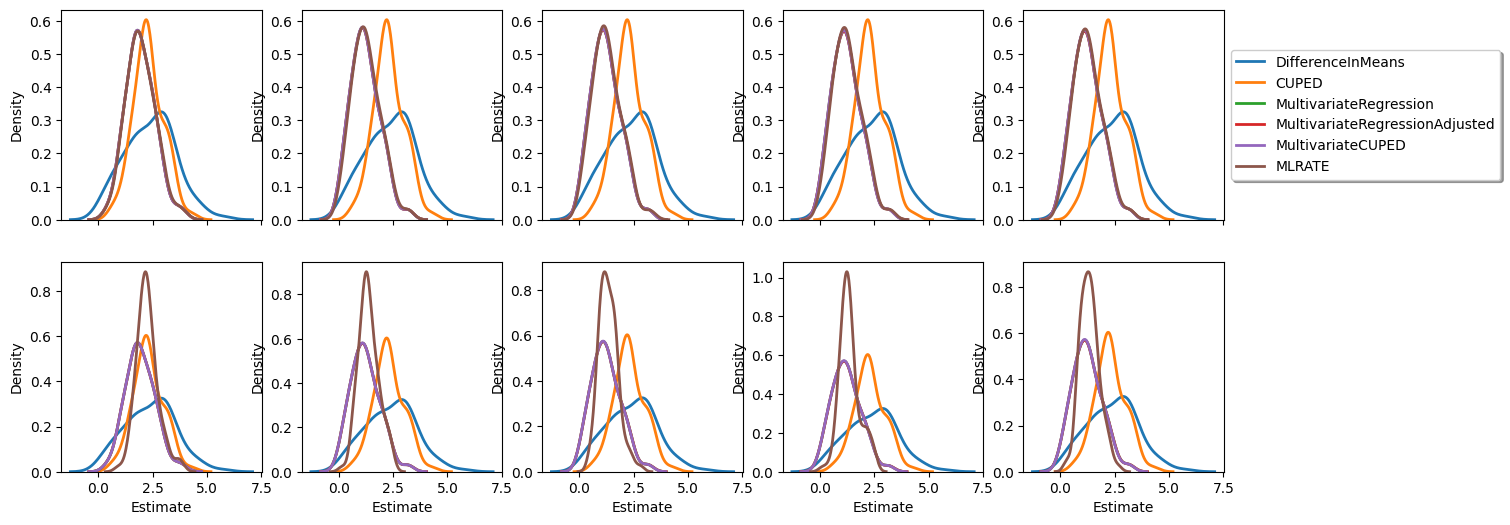

In [10]:
evaluation_grid.plot_grid()